## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Global pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format','{:.5f}'.format)

In [3]:
# Read in training data
df = pd.read_csv("./Data/train.csv", index_col='id')

In [4]:
df.index.name = None
df.head()

,qid1,qid2,question1,question2,is_duplicate
0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [5]:
train_df, test_df = train_test_split(df, random_state = 420)
train_df.head()

,qid1,qid2,question1,question2,is_duplicate
78422,133729,120568,Why do I feel like everyone hates me?,What should I do if I feel like everyone hates me? Am I going into a depression? What can I do not to hate myself?,0
317343,442532,442533,Design a server architecture for serving Google maps images?,Why is Austria not part of Google Street View?,0
97207,68425,61435,"What is the Sahara, and how do the average temperatures there compare to the ones in the Gibson Desert?","What is the Sahara, and how do the average temperatures there compare to the ones in the Taklamakan Desert?",1
69581,120053,120054,What are the main reason behind cancer diseases?,What was the main reason behind cancer disease?,1
282198,116675,117610,Are Apple watches worth it?,Is it worth getting the Apple Watch?,1


### Exploration

In [6]:
train_df.shape

(303217, 5)

In [7]:
# Check nulls
train_df.isnull().sum()

qid1            0
qid2            0
question1       1
question2       1
is_duplicate    0
dtype: int64

In [8]:
# Number of unique questions
q_unique = pd.Series(train_df['qid1'].to_list() + train_df['qid2'].to_list())
print('Unique questions in training set: ', len(q_unique.unique()))

Unique questions in training set:  427102


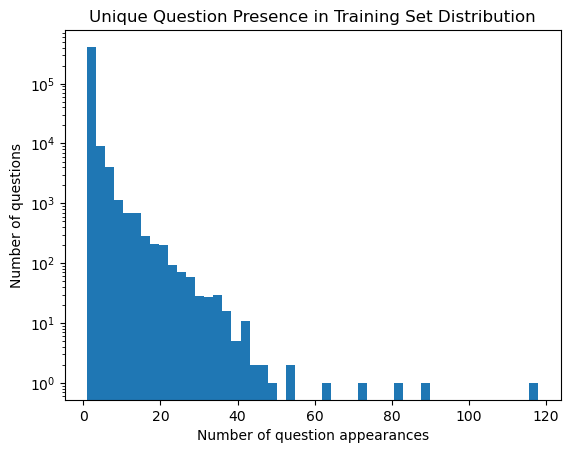

In [9]:
plt.figure()
plt.hist(q_unique.value_counts().to_list(), bins=50)
plt.title('Unique Question Presence in Training Set Distribution')
plt.xlabel('Number of question appearances')
plt.ylabel('Number of questions')
plt.yscale('log', nonpositive='clip')
plt.show()

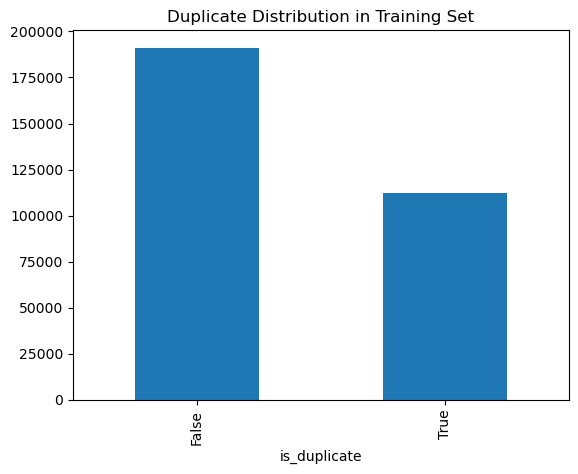

In [10]:
# Check target distribution
dup_count = train_df['is_duplicate'].astype('bool').value_counts()
dup_count.plot.bar()
plt.title('Duplicate Distribution in Training Set')
plt.show()

In [11]:
print('Baseline accuracy of assuming no duplicates: ', dup_count[0] / dup_count.sum())

Baseline accuracy of assuming no duplicates:  0.6304659699159348


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [12]:
# Fill null values with empty string
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

In [13]:
# Preprocess a question string
def preprocess_string(text: string):
    # Punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Lowercase
    text = text.lower()
    # Tokenize
    text = text.split()
    # Stopwords
    stop_words = stopwords.words('english')
    text = [word for word in text if word not in stop_words]
    # Stemming
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    # Join
    text = ' '.join(text)
    
    return text

# Preprocess training set
def preprocess_df(df: pd.DataFrame):
    df['preprocessed_q1'] = df['question1'].apply(lambda x: preprocess_string(x))
    df['preprocessed_q2'] = df['question2'].apply(lambda x: preprocess_string(x))
    return df
    

In [14]:
train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)

In [15]:
train_df.head()

,qid1,qid2,question1,question2,is_duplicate,preprocessed_q1,preprocessed_q2
78422,133729,120568,Why do I feel like everyone hates me?,What should I do if I feel like everyone hates me? Am I going into a depression? What can I do not to hate myself?,0,feel like everyon hate,feel like everyon hate go depress hate
317343,442532,442533,Design a server architecture for serving Google maps images?,Why is Austria not part of Google Street View?,0,design server architectur serv googl map imag,austria part googl street view
97207,68425,61435,"What is the Sahara, and how do the average temperatures there compare to the ones in the Gibson Desert?","What is the Sahara, and how do the average temperatures there compare to the ones in the Taklamakan Desert?",1,sahara averag temperatur compar one gibson desert,sahara averag temperatur compar one taklamakan desert
69581,120053,120054,What are the main reason behind cancer diseases?,What was the main reason behind cancer disease?,1,main reason behind cancer diseas,main reason behind cancer diseas
282198,116675,117610,Are Apple watches worth it?,Is it worth getting the Apple Watch?,1,appl watch worth,worth get appl watch


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [16]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=0.01)

# Combine questions in training set to train TFIDF
tfidf_train_data = pd.concat([train_df['preprocessed_q1'], train_df['preprocessed_q2']])

# Fit TFIDF on data
tfidf_trained = tfidf_vectorizer.fit(tfidf_train_data)


In [17]:
# Transform columns
tfidf_q1 = tfidf_trained.transform(train_df['preprocessed_q1'])
tfidf_q2 = tfidf_trained.transform(train_df['preprocessed_q2'])
tfidf_q1_test = tfidf_trained.transform(test_df['preprocessed_q1'])
tfidf_q2_test = tfidf_trained.transform(test_df['preprocessed_q2'])

# Create final matrices for model usage
X_train = hstack((tfidf_q1, tfidf_q2)).toarray()
y_train = train_df['is_duplicate'].to_list()
X_test = hstack((tfidf_q1_test, tfidf_q2_test)).toarray()
y_test = test_df['is_duplicate'].to_list()

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [18]:
# Balance classes
sm = SMOTE(random_state=420)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [20]:
# Grid search to tune hyperparameters
grid = {
    "C": [0.05, 0.1, 0.15, 0.2],
    "penalty": ["l1", "l2", 'elasticnet'],
    'l1_ratio': [0.1, 0.25]
}
logreg = LogisticRegression(n_jobs=-1)
logreg_cv = GridSearchCV(logreg,grid,cv=3)
logreg_cv.fit(X_res,y_res)
print(logreg_cv.best_params_)

{'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'l2'}


In [21]:
# Logistic Regression
logreg = LogisticRegression(n_jobs=-1, C=0.1, penalty='l2')
logreg.fit(X_res, y_res)
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
c_mtx = confusion_matrix(y_test, y_pred)
print('Accuracy: ', acc)
print('Precision: ', pre)
print('Recall: ', rec)
print('F1: ', f1)
print('Confusion Matrix: ', c_mtx)

Accuracy:  0.6252807376846438
Precision:  0.4908970539556438
Recall:  0.4782071263502983
F1:  0.48446900607083543
Confusion Matrix:  [[45403 18456]
 [19418 17796]]
